In [1]:
from qiskit.quantum_info import Statevector, Operator
from QuditsOnQubits import QuditsOnQubits
import numpy as np
import networkx as nx
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import igraph as ig

In [2]:
import sympy
from IPython.display import Math

Definicja Z i X qutrytowych zakodowanych na qubitach

In [11]:
def prtMTX(matrix):
    return Math(sympy.latex(sympy.Matrix(matrix)))

In [2]:
omega = np.exp(2*np.pi*1.j/3)
Z = [[1, 0, 0, 0], [0, omega, 0, 0], [0, 0, omega*omega, 0], [0, 0, 0, 1]]
X = [[0,0,1,0], [1,0,0,0], [0,1,0,0],[0,0,0,1]]

In [3]:
qubit0 = np.array([[1], [0]])
qubit1 = np.array([[0], [1]])

Qtrt0 = np.kron(qubit0, qubit0)
Qtrt1 = np.kron(qubit0, qubit1)
Qtrt2 = np.kron(qubit1, qubit0)

In [4]:
Qtrt0

array([[1],
       [0],
       [0],
       [0]])

In [5]:
Qtrt1

array([[0],
       [1],
       [0],
       [0]])

In [6]:
Qtrt2

array([[0],
       [0],
       [1],
       [0]])

Tworze graf ame43

In [154]:
sq = ig.Graph()

#dodawanie wezlow
sq.add_vertices(4)

#dodawanie kolejnych krawedzi
# SQ.add_edge(0, 1)
# SQ.add_edge(1, 2)
# SQ.add_edge(3, 0)
# SQ.add_edge(2, 3)
# SQ.add_edge(2, 3)

sq.add_edges([(0, 1), (1, 3), (1, 3), (2, 3), (0, 2)])


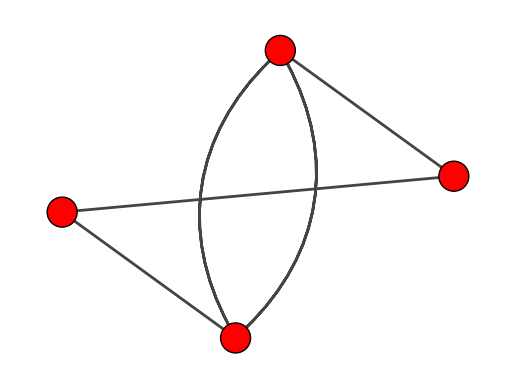

In [155]:
fig, ax = plt.subplots()
ig.plot(sq, target=ax)

Tworze stan grafowy uzywajac stworzonej biblioteki QuditsOnQubits gdzie w argumencie mam graf

In [156]:
ame43 = QuditsOnQubits(sq)

Tworze obwod z grafu

In [157]:
ame43circ = ame43.circuit

Tworze stabilizatory według pracy Santosa. Wzor nr. 42 na stronie 11.

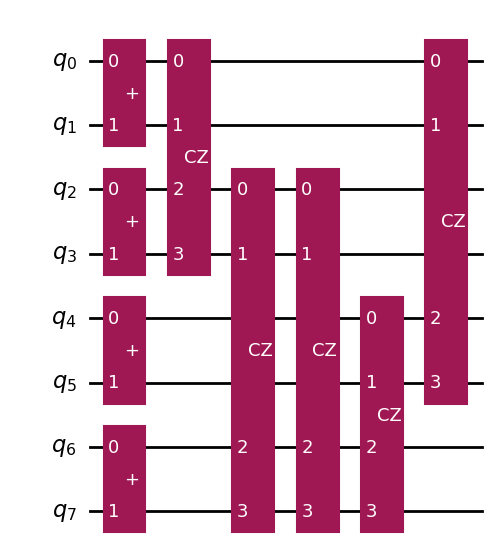

In [158]:
ame43circ.draw('mpl')

In [19]:
G1 = np.kron(np.kron(np.kron(X, Z), np.identity(4)), Z)
G1G2 = np.kron(np.kron(np.kron(np.dot(X, Z), np.dot(Z, X)), Z), Z)
G1G2pow2 = np.kron(np.kron(np.kron(multi_dot([X, Z, Z]), multi_dot([Z, X, X])), multi_dot([Z, Z])), Z)
G3 = np.kron(np.kron(np.kron(np.identity(4), Z), X), multi_dot([Z, Z]))
G1G4 = np.kron(np.kron(np.kron(multi_dot([X, Z]), Z), multi_dot([Z, Z])), multi_dot([Z, X]))

# G1 = np.kron(X, np.kron(Z, np.kron(np.identity(4), Z)))
# G1G2 = np.kron(np.dot(X, Z), np.kron(np.kron(Z, X), np.kron(Z, Z)))
# G1G2pow2 = np.kron(np.dot(X, np.dot(Z, Z)), np.kron(np.kron(Z, np.dot(X, X)), np.kron(np.dot(Z, Z), Z)))
# G3 = np.kron(np.identity(4), np.kron(Z, np.kron(X, np.dot(Z, Z))))
# G1G4 = np.kron(np.dot(X, Z), np.kron(Z, np.kron(np.dot(Z, Z), np.dot(Z, X))))

In [20]:
G1.shape

(256, 256)

Odczytuje stan z obwodu ktory stworzylem

In [159]:
ame43state = Statevector(ame43circ).data

Obliczam wartosc oczekiwana stabilizatora G1

In [22]:
ame43state

array([ 1.11111111e-01+7.84095011e-16j,  1.11111111e-01+9.78384040e-16j,
        1.11111111e-01+4.30211422e-16j, -1.50608508e-16+5.47790025e-16j,
        1.11111111e-01+9.08995101e-16j, -5.55555556e-02+9.62250449e-02j,
       -5.55555556e-02-9.62250449e-02j, -1.50608508e-16+5.47790025e-16j,
        1.11111111e-01+4.09394740e-16j, -5.55555556e-02-9.62250449e-02j,
       -5.55555556e-02+9.62250449e-02j, -1.50608508e-16+5.47790025e-16j,
       -1.40467117e-16+5.34486498e-16j, -1.41613276e-16+5.31542012e-16j,
       -1.55192142e-16+5.41954881e-16j, -2.43818858e-30-1.54926497e-30j,
        1.11111111e-01+9.15933995e-16j,  1.11111111e-01+1.09634524e-15j,
        1.11111111e-01+5.06539255e-16j, -1.50608508e-16+5.47790025e-16j,
       -5.55555556e-02+9.62250449e-02j, -5.55555556e-02-9.62250449e-02j,
        1.11111111e-01+6.59194921e-16j, -3.99095824e-16-4.04325807e-16j,
       -5.55555556e-02-9.62250449e-02j, -5.55555556e-02+9.62250449e-02j,
        1.11111111e-01+1.66533454e-16j,  5.49704332

In [23]:
ame43matrix = ame43state.reshape(256, 1)

In [24]:
multi_dot([ame43state.conj().transpose(), G1, ame43state])

np.complex128(-2.9698465908722937e-15-1.5440032753063703e-15j)

In [25]:
#G1ev = ame43state.expectation_value(G1)

Sprawdzam recznie ten stan ame43

In [26]:
Zsolo = [[1, 0, 0], [0, omega, 0], [0, 0, omega*omega]]
Xsolo = [[0,0,1], [1,0,0], [0,1,0]]

In [27]:
qutryt0 = np.array([[1], [0], [0]])
qutryt1 = np.array([[0], [1], [0]])
qutryt2 = np.array([[0], [0], [1]])

In [28]:
plusQutryt = 1/np.sqrt(3) * (qutryt0 + qutryt1 + qutryt2)

Bramka CZ jest diagonalna i ma na diagonali $\omega^{i * j}$, gdzie i oraz j to kombinacje wszystkich qutrytow np. $\ket{0, 0}$ mamy $\omega^{0 * 0}$, dla $\ket{0, 1}$ mamy $\omega^{0 * 1}$ itd

In [29]:
CZqutryt = np.diag([1, 1, 1, 1, omega, omega*omega, 1, omega*omega, omega])

Robie plusy na kazdym wierzcholku

In [30]:
stanPlus = np.kron(np.kron(np.kron(plusQutryt, plusQutryt), plusQutryt), plusQutryt)

In [31]:
stanPlus.shape

(81, 1)

In [32]:
CZ01 = np.kron(CZqutryt, np.kron(np.identity(3), np.identity(3)))
CZ12 = np.kron(np.identity(3), np.kron(CZqutryt, np.identity(3)))
CZ23 = np.kron(np.identity(3), np.kron(np.identity(3), CZqutryt))

Robie funkcje poniewaz nie moge bezposrednio uzyc np.kron bo qutryty nie sa obok siebie tylko na dwoch koncach, wiec tworze juz caly stan CZ03 odrazu.

In [33]:
def CZ_30_4qutrits():
    d = 3
    dim = d**4
    diag_elements = np.zeros(dim, dtype=complex)

    omegaCZ = np.exp(2j * np.pi / d)

    index = 0
    for x0 in range(d):
        for x1 in range(d):
            for x2 in range(d):
                for x3 in range(d):
                    
                    diag_elements[index] = omegaCZ ** (x0 * x3)
                    index += 1

    return np.diag(diag_elements)

CZ30 = CZ_30_4qutrits()

Robie CZ na kazdej krawedzi i lacze ze stanem plus na kazdym wierzcholku

In [34]:
ame43test = multi_dot([CZ01, CZ12, CZ23, CZ23, CZ30, stanPlus])

In [35]:
stanPlus.shape

(81, 1)

In [36]:
ame43test.shape

(81, 1)

Analogicznie do tworzenia poprzednich stabilizatorow

In [37]:
G1test = np.kron(np.kron(np.kron(Xsolo, Zsolo), np.identity(3)), Zsolo)
G1G2test = np.kron(np.kron(np.kron(np.dot(Xsolo, Zsolo), np.dot(Zsolo, Xsolo)), Zsolo), Zsolo)
G1G2pow2test = np.kron(np.kron(np.kron(multi_dot([Xsolo, Zsolo, Zsolo]), multi_dot([Zsolo, Xsolo, Xsolo])), multi_dot([Zsolo, Zsolo])), Zsolo)
G3test = np.kron(np.kron(np.kron(np.identity(3), Zsolo), Xsolo), multi_dot([Zsolo, Zsolo]))
G1G4test = np.kron(np.kron(np.kron(multi_dot([Xsolo, Zsolo]), Zsolo), multi_dot([Zsolo, Zsolo])), multi_dot([Zsolo, Xsolo]))

# G1test = np.kron(Xsolo, np.kron(Zsolo, np.kron(np.identity(3), Zsolo)))
# G1G2test = np.kron(np.dot(Xsolo, Zsolo), np.kron(np.kron(Zsolo, Xsolo), np.kron(Zsolo, Zsolo)))
# G1G2pow2test = np.kron(np.dot(Xsolo, np.dot(Zsolo, Zsolo)), np.kron(np.kron(Zsolo, np.dot(Xsolo, Xsolo)), np.kron(np.dot(Zsolo, Zsolo), Zsolo)))
# G3test = np.kron(np.identity(3), np.kron(Zsolo, np.kron(Xsolo, np.dot(Zsolo, Zsolo))))
# G1G4test = np.kron(np.dot(Xsolo, Zsolo), np.kron(Zsolo, np.kron(np.dot(Zsolo, Zsolo), np.dot(Zsolo, Xsolo))))

Obliczam recznie $\braket{ame43|G1|ame43}$

In [38]:
multi_dot([ame43test.conj().transpose(), G1test, ame43test])

array([[1.-4.21537805e-16j]])

In [39]:
operatory = [G1test, G1G2test, G1G2pow2test, G3test, G1G4test]

In [40]:
suma = 0
for i in operatory:
    suma += np.real(multi_dot([ame43test.conj().transpose(), i, ame43test]))
    print(np.real(multi_dot([ame43test.conj().transpose(), i, ame43test])))
    
print(suma)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[5.]]


In [41]:
def exp_val(op):
    return np.real(multi_dot([ame43test.conj().transpose(), op, ame43test]))

In [42]:
B_ame = G1test + G1G2pow2test + 0.5*(G1G2test + G1G4test) + G3test + G1test.conj().T + G1G2pow2test.conj().T + 0.5*(G1G2test.conj().T + G1G4test.conj().T) + G3test.conj().T

In [43]:
np.real(multi_dot([ame43test.conj().transpose(), B_ame, ame43test]))

array([[8.]])

In [44]:
vect_sympy = sympy.Matrix(Statevector(ame43circ).data.round(5).reshape((256, 1)))
vect_sympy2 = sympy.Matrix(Statevector(ame43test).data.round(5).reshape((81, 1)))

Porownanie z wczesniejszym wynikiem

Statevector qutrytowy zwykły bez kodowania policzony ręcznie

In [45]:
Statevector(ame43test).draw('latex')

<IPython.core.display.Latex object>

In [46]:
format(1, '08b')

'00000001'

In [ ]:
Math(sympy.latex(vect_sympy2))

Statevector qutrytowy zakodowany na qubitach z algorytmu

In [48]:
Statevector(ame43circ).draw('latex')

<IPython.core.display.Latex object>

In [ ]:
Math(sympy.latex(vect_sympy))

In [50]:
nonzero_dict = Statevector(ame43test).to_dict()
num_terms = len(nonzero_dict)
print("Liczba niezerowych składników w tym Statevector:", num_terms)

Liczba niezerowych składników w tym Statevector: 81


Poniżej brudnopis, próbowałem policzyć wartości oczekiwane dla naszego podstawowego stanu GHZ.

In [51]:
ghz_circ = QuditsOnQubits().circuit[1]

In [52]:
ghz_circ

array([[-5.77350269e-01-3.95243214e-15j],
       [ 1.67231961e-17-5.70531277e-17j],
       [-2.95360966e-17-7.70988212e-18j],
       [ 7.82584766e-16-2.84640047e-15j],
       [-6.95808573e-17+2.70597771e-16j],
       [ 1.72181302e-15-6.52394803e-16j],
       [-9.38366847e-18-1.94491073e-17j],
       [-8.01751384e-31-9.32244759e-31j],
       [ 1.57368925e-15-6.62931985e-16j],
       [-3.62098557e-18+1.16542063e-17j],
       [ 2.28774619e-16+2.54551119e-16j],
       [ 9.37868610e-31+8.37042798e-30j],
       [ 2.58996946e-16-1.73004099e-15j],
       [ 1.92401140e-31+6.05637679e-30j],
       [-9.14242598e-31+5.50895484e-31j],
       [ 8.15876186e-30+4.01870155e-30j],
       [-1.10428400e-16+2.25220175e-16j],
       [ 1.77269824e-15-6.57461581e-16j],
       [ 9.12004861e-18-2.10464381e-17j],
       [-1.06339416e-30-9.05438080e-31j],
       [-3.61240573e-17-2.56528861e-17j],
       [-5.77350269e-01-4.48651244e-15j],
       [ 0.00000000e+00-2.79486768e-18j],
       [ 3.13658534e-32+1.91836976

In [53]:
Statevector(ghz_circ).draw('latex')

<IPython.core.display.Latex object>

In [54]:
Statevector(ghz_circ).data.round(5)

array([-0.57735-0.j,  0.     -0.j, -0.     -0.j,  0.     -0.j,
       -0.     +0.j,  0.     -0.j, -0.     -0.j, -0.     -0.j,
        0.     -0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j,
        0.     -0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j,
       -0.     +0.j,  0.     -0.j,  0.     -0.j, -0.     -0.j,
       -0.     -0.j, -0.57735-0.j,  0.     -0.j,  0.     +0.j,
       -0.     +0.j,  0.     +0.j,  0.     -0.j, -0.     +0.j,
       -0.     -0.j,  0.     -0.j, -0.     +0.j,  0.     -0.j,
        0.     -0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,
       -0.     +0.j,  0.     +0.j,  0.     -0.j, -0.     +0.j,
       -0.     +0.j,  0.     -0.j, -0.57735-0.j, -0.     +0.j,
        0.     +0.j, -0.     +0.j,  0.     -0.j, -0.     -0.j,
        0.     -0.j,  0.     +0.j,  0.     -0.j,  0.     +0.j,
        0.     -0.j,  0.     -0.j, -0.     +0.j, -0.     +0.j,
       -0.     -0.j,  0.     +0.j,  0.     -0.j,  0.     -0.j,
        0.     +0.j,  0.     +0.j,  0.     +0.j, -0.   

In [55]:
sum = 0
for i in Statevector(ghz_circ).data.round(5):
    if i != 0:
        sum += 1

In [56]:
sum

3

In [57]:
ghz_matrix = (-1) * Statevector(ghz_circ)

In [58]:
ghz_matrix.draw('latex')

<IPython.core.display.Latex object>

$\ket{000}$ + $\ket{111}$ + $\ket{222}$

In [59]:
Id = np.identity(4)

Zmienic generatory na baze taka w jakiej jest ghz

Sprawdzic wszystkie mozliwosci dla stabilizatorow, porownac z orginalnymi stabilizatorami i jak przejsc z orginalnych do tych co wyszly

In [60]:
g1 = np.kron(np.kron(Z, X), X)
g2 = np.kron(np.kron(X, Z), np.identity(4))
g3 = np.kron(np.kron(X, np.identity(4)), Z)

In [61]:
multi_dot([Statevector(ghz_circ).data.conj().transpose(), g1, Statevector(ghz_circ).data])

np.complex128(-2.4421441894360897e-16+1.5402969882312747e-18j)

In [62]:
obs_ghz = [Z, X, Id]
obs_ghz_text = ["Z", "X", "I"]

In [63]:
for i, i2 in zip(obs_ghz, obs_ghz_text):
    for j, j2 in zip(obs_ghz, obs_ghz_text):
        for k, k2 in zip(obs_ghz, obs_ghz_text):
            gener = np.kron(np.kron(i, j), k)
            war_ocz = multi_dot([Statevector(ghz_circ).data.conj().transpose(), gener, Statevector(ghz_circ).data])
            if war_ocz.round(4) != 0:
                print(f'{i2}{j2}{k2}: {war_ocz.round(4)}')

ZZZ: (1-0j)
XXX: (1+0j)
III: (1+0j)


In [64]:
g1.shape

(64, 64)

In [65]:
def stabilizator_finder(psi, Z, X, I):
    ops = [Z, X, I]
    names = ["Z", "X", "I"]
    result_dict = {}
    for (i, i_name) in zip(ops, names):
        for (j, j_name) in zip(ops, names):
            for (k, k_name) in zip(ops, names):
                gen = np.kron(np.kron(i, j), k)
                ev = multi_dot([psi.conj().transpose(), gen, psi])
                result_dict[f'{i_name}{j_name}{k_name}'] = np.real(ev.round(5).item())

    nonzero = {}

    for i in result_dict:
        if result_dict[i] != 0:
            nonzero[i] = result_dict[i]

    return [result_dict, nonzero]

In [66]:
res = stabilizator_finder(ghz_matrix.data, Z, X, Id)

In [67]:
res[1]

{'ZZZ': 1.0, 'XXX': 1.0, 'III': 1.0}

In [68]:
res

[{'ZZZ': 1.0,
  'ZZX': -0.0,
  'ZZI': -0.0,
  'ZXZ': 0.0,
  'ZXX': -0.0,
  'ZXI': 0.0,
  'ZIZ': -0.0,
  'ZIX': -0.0,
  'ZII': -0.0,
  'XZZ': 0.0,
  'XZX': -0.0,
  'XZI': 0.0,
  'XXZ': -0.0,
  'XXX': 1.0,
  'XXI': 0.0,
  'XIZ': 0.0,
  'XIX': -0.0,
  'XII': -0.0,
  'IZZ': -0.0,
  'IZX': -0.0,
  'IZI': -0.0,
  'IXZ': 0.0,
  'IXX': -0.0,
  'IXI': -0.0,
  'IIZ': -0.0,
  'IIX': 0.0,
  'III': 1.0},
 {'ZZZ': 1.0, 'XXX': 1.0, 'III': 1.0}]

Przed zmiana bazy na baze podstawowa

In [69]:
ghz_circ_raw = QuditsOnQubits().circuit[0]

In [70]:
Statevector(ghz_circ_raw).draw('latex')

<IPython.core.display.Latex object>

In [71]:
ghz_raw_mtx = Statevector(ghz_circ_raw).data

In [72]:
np.count_nonzero(ghz_raw_mtx)

64

In [73]:
ghz_raw_obs = stabilizator_finder(ghz_raw_mtx, Z, X, Id)

In [74]:
ghz_raw_obs[1]

{'ZZX': 1.0, 'XIZ': 1.0, 'IXZ': 1.0, 'III': 1.0}

In [75]:
from itertools import product

In [76]:
def ame43_checker_gen(ameMTX, Z, X, I):
    ops = [Z, X, I]
    names = ["Z", "X", "I"]

    G1_dict = {}
    G1G2_dict = {}
    G1G2pow2_dict = {}
    G3_dict = {}
    G1G4_dict = {}

    tensor_symbol = "\u2297"

    for combination in product(zip(ops, names), repeat=9):

            if len(G1_dict) > 2 and len(G1G2_dict) > 2 and len(G1G2pow2_dict) > 2 and len(G3_dict) > 2 and len(G1G4_dict) > 2:
                break

            (i, i2), (j, j2), (k, k2), (l, l2), (m, m2), (n, n2), (o, o2), (p, p2), (q, q2) = combination
            G1 = np.kron(np.kron(np.kron(i, j), k), l)
            G1G2 = np.kron(np.kron(np.kron(np.dot(i, j), np.dot(k, l)), m), n)
            G1G2pow2 = np.kron(np.kron(np.kron(multi_dot([i, j, k]), multi_dot([l, m, n])), multi_dot([o, p])), q)
            G3 = np.kron(np.kron(np.kron(i, j), k), multi_dot([l, m]))
            G1G4 = np.kron(np.kron(np.kron(multi_dot([i, j]), k), multi_dot([l, m])), multi_dot([n, o]))

            G1_text = f'{i2}{tensor_symbol}{j2}{tensor_symbol}{k2}{tensor_symbol}{l2}'

            G1G2_text = f'{i2}{j2}{tensor_symbol}{k2}{l2}{tensor_symbol}{m2}{tensor_symbol}{n2}'

            G1G2pow2_text = f'{i2}{j2}{k2}{tensor_symbol}{l2}{m2}{n2}{tensor_symbol}{o2}{p2}{tensor_symbol}{q2}'

            G3_text = f'{i2}{tensor_symbol}{j2}{tensor_symbol}{k2}{tensor_symbol}{l2}{m2}'

            G1G4_text = f'{i2}{j2}{tensor_symbol}{k2}{tensor_symbol}{l2}{m2}{tensor_symbol}{n2}{o2}'

            evG1 = multi_dot([ameMTX.conj().transpose(), G1, ameMTX])
            evG1G2 = multi_dot([ameMTX.conj().transpose(), G1G2, ameMTX])
            evG1G2pow2 = multi_dot([ameMTX.conj().transpose(), G1G2pow2, ameMTX])
            evG3 = multi_dot([ameMTX.conj().transpose(), G3, ameMTX])
            evG1G4 = multi_dot([ameMTX.conj().transpose(), G1G4, ameMTX])

            ev_list = [evG1, evG1G2, evG1G2pow2, evG3, evG1G4]

            if evG1.round(4) != 0 and G1_text not in G1_dict:
                G1_dict[G1_text] = evG1.round(4)
            if evG1G2.round(4) != 0 and G1G2_text not in G1G2_dict:
                G1G2_dict[G1G2_text] = evG1G2.round(4)
            if evG1G2pow2.round(4) != 0 and G1G2pow2_text not in G1G2pow2_dict:
                G1G2pow2_dict[G1G2pow2_text] = evG1G2pow2.round(4)
            if evG3.round(4) != 0 and G3_text not in G3_dict:
                G3_dict[G3_text] = evG3.round(4)
            if evG1G4.round(4) != 0 and G1G4_text not in G1G4_dict:
                G1G4_dict[G1G4_text] = evG1G4.round(4)

            if any(x.round(4) != 0 for x in ev_list):
                print(f'G1: {G1_text} => {evG1.round(4)}')
                print(f'G1G2: {G1G2_text} => {evG1G2.round(4)}')
                print(f'G1G2pow2: {G1G2pow2_text} => {evG1G2pow2.round(4)}')
                print(f'G3: {G3_text} => {evG3.round(4)}')
                print(f'G1G4: {G1G4_text} => {evG1G4.round(4)}')
                print("----------------------------------")

    return G1_dict, G1G2_dict, G1G2pow2_dict, G3_dict, G1G4_dict



In [77]:
#g1List, g1g2List, g1g2pow2List, g3List, g1g4List = ame43_checker_gen(ame43state, Z, X, Id)

Reczne obliczanie zakodowanego ame43 na qubitach

In [78]:
enQ0 = np.kron(qubit0, qubit0)
enQ1 = np.kron(qubit0, qubit1)
enQ2 = np.kron(qubit1, qubit0)

In [79]:
pi = np.pi
sqrt = np.sqrt
log = np.log

common_log_term = log(-1 / 6 * (-1) ** (1 / 4) * (sqrt(24 - 6 * sqrt(3)) + 1j * (3 + sqrt(3))))
common_factor = 3j + 1j * sqrt(3) + sqrt(6 * (4 - sqrt(3)))
denominator = 15 * pi - 4 * 1j * common_log_term

VCx = np.array([
    [
        -(((-1) ** (5 / 8) * common_factor * (30 * pi - 8 * 1j * common_log_term)) / (24 * denominator)) +
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator),
        0,
        0,
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator) -
        ((-1) ** (5 / 8) * common_factor * (-30 * pi + 8 * 1j * common_log_term)) / (24 * denominator)
    ],
    [
        0,
        -(1 / 2) * (-1) ** (1 / 8) - (1 / 2) * (-1) ** (5 / 8),
        -(1 / 2) * (-1) ** (1 / 8) + (1 / 2) * (-1) ** (5 / 8),
        0
    ],
    [
        0,
        -(1 / 2) * (-1) ** (1 / 8) + (1 / 2) * (-1) ** (5 / 8),
        -(1 / 2) * (-1) ** (1 / 8) - (1 / 2) * (-1) ** (5 / 8),
        0
    ],
    [
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator) -
        ((-1) ** (5 / 8) * common_factor * (-30 * pi + 8 * 1j * common_log_term)) / (24 * denominator),
        0,
        0,
        -(((-1) ** (5 / 8) * common_factor * (30 * pi - 8 * 1j * common_log_term)) / (24 * denominator)) +
        (3 * (-1) ** (5 / 8) * (-30 * pi + 8 * 1j * common_log_term)) / (2 * common_factor * denominator)
    ]
], dtype=complex)

In [80]:
Statevector(ame43circ).data.round(5)

array([ 0.11111+0.j     ,  0.11111+0.j     ,  0.11111+0.j     ,
       -0.     +0.j     ,  0.11111+0.j     , -0.05556+0.09623j,
       -0.05556-0.09623j, -0.     +0.j     ,  0.11111+0.j     ,
       -0.05556-0.09623j, -0.05556+0.09623j, -0.     +0.j     ,
       -0.     +0.j     , -0.     +0.j     , -0.     +0.j     ,
       -0.     -0.j     ,  0.11111+0.j     ,  0.11111+0.j     ,
        0.11111+0.j     , -0.     +0.j     , -0.05556+0.09623j,
       -0.05556-0.09623j,  0.11111+0.j     , -0.     -0.j     ,
       -0.05556-0.09623j, -0.05556+0.09623j,  0.11111+0.j     ,
        0.     -0.j     , -0.     +0.j     , -0.     +0.j     ,
       -0.     +0.j     , -0.     -0.j     ,  0.11111+0.j     ,
        0.11111+0.j     ,  0.11111+0.j     , -0.     +0.j     ,
       -0.05556-0.09623j,  0.11111+0.j     , -0.05556+0.09623j,
        0.     -0.j     , -0.05556+0.09623j,  0.11111+0.j     ,
       -0.05556-0.09623j, -0.     -0.j     , -0.     +0.j     ,
       -0.     +0.j     , -0.     +0.j  

In [ ]:
Math(sympy.latex(vect_sympy2))

In [82]:
from qiskit.circuit import QuantumCircuit
import numpy as np

def CZqutrit():
    circ = QuantumCircuit(4, name="CZ")

    omegaCZ = 2*np.pi/3

    circ.cp(omegaCZ, 2, 0)
    circ.cp(omegaCZ, 3, 1)
    circ.cp(-1 * omegaCZ, 3, 0)
    circ.cp(-1 * omegaCZ, 2, 1)

    return circ

In [83]:
CzCirc = QuantumCircuit(4)
CzCirc.h(0)
CzCirc.append(CZqutrit(), [0, 1, 2, 3])

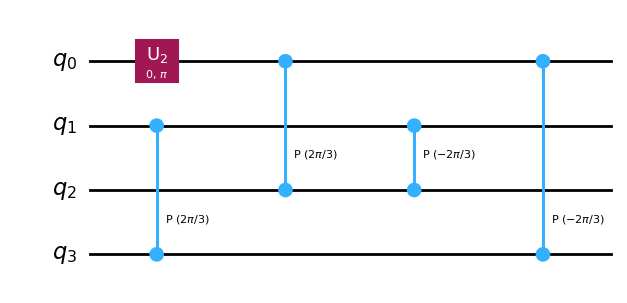

In [84]:
CzCirc.decompose().draw('mpl')

In [85]:
from qiskit.quantum_info import Statevector
mtx = Statevector(CzCirc).to_operator()

In [86]:
mtx

Operator([[0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j

In [87]:
mtx

Operator([[0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j],
          [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
           0. +0.j, 0. +0.j, 0. +0.j

In [88]:
def CZ_03_encoded_qutrits():
    # Definicje
    omega = np.exp(2j * np.pi / 3)
    diag_elements = np.ones(2**8, dtype=complex)  # 4 qutryty = 8 qubitów

    # Kodowanie: 0 = '00', 1 = '10', 2 = '01'
    encoding = {'00':0, '10':1, '01':2}

    for idx in range(2**8):
        binary_state = format(idx, '08b')  # stan qubitów: q0q1 q2q3 q4q5 q6q7

        qutrit0_bits = binary_state[0:2]
        qutrit3_bits = binary_state[6:8]

        # Sprawdź czy bity odpowiadają poprawnemu kodowaniu qutrytów
        if qutrit0_bits in encoding and qutrit3_bits in encoding:
            qutrit0 = encoding[qutrit0_bits]
            qutrit3 = encoding[qutrit3_bits]

            diag_elements[idx] = omega ** (qutrit0 * qutrit3)
        else:
            # stany spoza kodowania (np. '11') pozostają z wartością 1
            diag_elements[idx] = 1

    return np.diag(diag_elements)

In [89]:
cz4d = CZ_03_encoded_qutrits()

In [90]:
CZqutryt_2d = np.diag([1, 1, 1, 1, 1, omega, omega*omega, 1, 1, omega*omega, omega, 1, 1, 1, 1, 1])
CZqutryt_2d[0].shape

(16,)

In [91]:
prtMTX(CZqutryt_2d)

<IPython.core.display.Math object>

In [92]:
omega

np.complex128(-0.4999999999999998+0.8660254037844387j)

In [93]:
CZ01_4d = np.kron(CZqutryt_2d, np.kron(np.identity(4), np.identity(4)))
CZ12_4d = np.kron(np.identity(4), np.kron(CZqutryt_2d, np.identity(4)))
CZ23_4d = np.kron(np.identity(4), np.kron(np.identity(4), CZqutryt_2d))

In [94]:
CZ03_4d = CZ_03_encoded_qutrits()

In [95]:
Math(sympy.latex(CZ03_4d))

<IPython.core.display.Math object>

In [96]:
Math(sympy.latex(CZ30))

<IPython.core.display.Math object>

In [97]:
F = 1/np.sqrt(3) * np.array([[1, 1, 1, 0], [1, omega, omega*omega, 0], [1, omega*omega, omega, 0], [0, 0, 0, 1]])

In [98]:
Math(sympy.latex(F))

<IPython.core.display.Math object>

In [99]:
stanPlus_4d = multi_dot([F, enQ0])

In [100]:
stanPlus_4d.shape

(4, 1)

In [101]:
stanPlus_4d_all = np.kron(stanPlus_4d, np.kron(stanPlus_4d, np.kron(stanPlus_4d, stanPlus_4d)))

In [102]:
stanPlus_4d_all.shape

(256, 1)

In [103]:
ame43_4d = multi_dot([CZ01_4d, CZ12_4d, CZ23_4d, CZ23_4d, stanPlus_4d_all])

In [104]:
ame43_4d.shape

(256, 1)

In [105]:
ame43matrix.shape

(256, 1)

In [ ]:
Math(sympy.latex(sympy.Matrix(ame43_4d.round(5))))

In [ ]:
Math(sympy.latex(sympy.Matrix(ame43matrix.round(5))))

In [108]:
ame43_4d[0].round(5)

array([0.11111+0.j])

In [109]:
ame43_4d

array([[ 0.11111111+0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [ 0.        +0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [-0.05555556-9.62250449e-02j],
       [-0.05555556+9.62250449e-02j],
       [ 0.        +0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [-0.05555556+9.62250449e-02j],
       [-0.05555556-9.62250449e-02j],
       [ 0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [ 0.11111111+0.00000000e+00j],
       [ 0.        +0.00000000e+00j],
       [-0.05555556+9.62250449e-02j],
       [ 0.11111111-6.93889390e-17j],
       [-0.05555556-9.62250449e-02j],
       [ 0.        +0.00000000e+00j],
       [-0.05555556-9.62250449e-02j],
       [ 0.11111111-1.45716772e-16j],
       [-0.0

In [110]:
def check_ame43_diff():
    same = []
    diff = []
    for i in range(len(ame43_4d)):
        if ame43_4d[i].round(5) == ame43matrix[i].round(5):
            same.append((i, ame43_4d[i], ame43matrix[i]))
        else:
            diff.append((i, ame43_4d[i].round(5), ame43matrix[i].round(5)))

    return [same, diff]

In [111]:
check = check_ame43_diff()

In [112]:
print(f'index || ame43_4d || ame43matrix')
for i in check[1]:
    print(f'{i[0]} || {i[1]} || {i[2]} ')

index || ame43_4d || ame43matrix
5 || [-0.05556-0.09623j] || [-0.05556+0.09623j] 
6 || [-0.05556+0.09623j] || [-0.05556-0.09623j] 
9 || [-0.05556+0.09623j] || [-0.05556-0.09623j] 
10 || [-0.05556-0.09623j] || [-0.05556+0.09623j] 
21 || [0.11111-0.j] || [-0.05556-0.09623j] 
22 || [-0.05556-0.09623j] || [0.11111+0.j] 
25 || [0.11111-0.j] || [-0.05556+0.09623j] 
26 || [-0.05556+0.09623j] || [0.11111+0.j] 
37 || [-0.05556+0.09623j] || [0.11111+0.j] 
38 || [0.11111-0.j] || [-0.05556+0.09623j] 
41 || [-0.05556-0.09623j] || [0.11111+0.j] 
42 || [0.11111-0.j] || [-0.05556-0.09623j] 
65 || [0.11111+0.j] || [-0.05556+0.09623j] 
66 || [0.11111+0.j] || [-0.05556-0.09623j] 
73 || [-0.05556+0.09623j] || [0.11111+0.j] 
74 || [-0.05556-0.09623j] || [0.11111+0.j] 
80 || [-0.05556+0.09623j] || [-0.05556-0.09623j] 
81 || [-0.05556+0.09623j] || [0.11111+0.j] 
84 || [-0.05556-0.09623j] || [0.11111+0.j] 
85 || [-0.05556+0.09623j] || [-0.05556-0.09623j] 
86 || [0.11111-0.j] || [-0.05556+0.09623j] 
88 || [0.1

In [113]:
np.array_equal(ame43_4d.round(5), ame43matrix.round(5))

False

In [114]:
Z_4d = np.array([[1, 0, 0, 0], [0, omega, 0, 0], [0, 0, omega*omega, 0], [0, 0, 0, 1]])

In [115]:
Math(sympy.latex(sympy.Matrix(Z_4d)))

<IPython.core.display.Math object>

In [116]:
X_4d = np.array([[0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

In [117]:
prtMTX(np.kron(qubit1, qubit1))

<IPython.core.display.Math object>

In [118]:
prtMTX(multi_dot([X_4d, np.kron(qubit1, qubit1)]))

<IPython.core.display.Math object>

In [119]:
G1_4d = np.kron(np.kron(np.kron(X_4d, Z_4d), np.identity(4)), Z_4d)
G1G2_4d = np.kron(np.kron(np.kron(np.dot(X_4d, Z_4d), np.dot(Z_4d, X_4d)), Z_4d), Z_4d)
G1G2pow2_4d = np.kron(np.kron(np.kron(multi_dot([X_4d, Z_4d, Z_4d]), multi_dot([Z_4d, X_4d, X_4d])), multi_dot([Z_4d, Z_4d])), Z_4d)
G3_4d = np.kron(np.kron(np.kron(np.identity(4), Z_4d), X_4d), multi_dot([Z_4d, Z_4d]))
G1G4_4d = np.kron(np.kron(np.kron(multi_dot([X_4d, Z_4d]), Z_4d), multi_dot([Z_4d, Z_4d])), multi_dot([Z_4d, X_4d]))

In [120]:
wynik_4d = np.real(multi_dot([ame43_4d.conj().transpose(),G1_4d , ame43_4d]))

In [121]:
Math(sympy.latex(wynik_4d))

<IPython.core.display.Math object>

In [122]:
#g1List_4d, g1g2List_4d, g1g2pow2List_4d, g3List_4d, g1g4List_4d = ame43_checker_gen(ame43_4d, Z, X, Id)

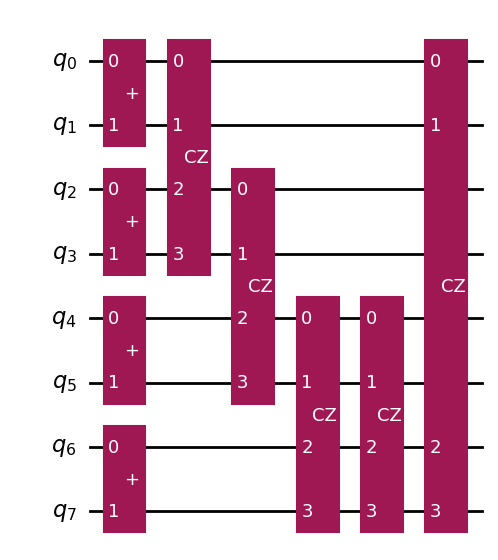

In [123]:
ame43.circuit.draw('mpl')

In [124]:
def change_base(psi, F):
    oper = [Operator(np.identity(4)), Operator(F), Operator(F).conjugate().transpose(), Operator(X), Operator(Z)]
    oper_text = ["I", "F", "F+", "X", "Z"]

    psi_dict = {}

    for combination in product(zip(oper, oper_text), repeat=4):
        (i, i2), (j, j2), (k, k2), (l, l2) = combination
        changeOperator = i.tensor(j).tensor(k).tensor(l).to_matrix()

        changed = multi_dot([changeOperator, psi])

        psi_dict[f'{i2}{j2}{k2}{l2}'] = changed

        if changed.shape[0] < 10:

            print(Statevector(changed).draw('latex'))

    return psi_dict

In [125]:
Fgate = QuditsOnQubits().circuit[2]

In [126]:
Statevector(Fgate).draw('latex')

<IPython.core.display.Latex object>

In [127]:
ame_changed_dict = change_base(Statevector(ame43circ), Fgate)

In [128]:
len(ame_changed_dict)

625

In [129]:
list(ame_changed_dict.values())[0].shape[0]

256

In [ ]:
prtMTX(ame43_4d)

In [131]:
ameTEST_changed_dict = change_base(ame43_4d, Fgate)

In [132]:
len(ameTEST_changed_dict)

625

In [133]:
dictKEYS = list(ame_changed_dict.keys())

In [134]:
Statevector(ameTEST_changed_dict['IF+F+F']).draw('latex')

<IPython.core.display.Latex object>

In [135]:
len(Statevector(ameTEST_changed_dict['F+FII']))

256

In [136]:
ameTEST_changed_dict['F+FII']

array([[ 1.11111111e-01+1.45129918e-17j],
       [ 1.11111111e-01+1.45129918e-17j],
       [ 1.11111111e-01+1.45129918e-17j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 1.11111111e-01+3.96345754e-16j],
       [-5.55555556e-02-9.62250449e-02j],
       [-5.55555556e-02+9.62250449e-02j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 1.11111111e-01-1.42710504e-16j],
       [-5.55555556e-02+9.62250449e-02j],
       [-5.55555556e-02-9.62250449e-02j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 1.11111111e-01+5.30588601e-16j],
       [ 1.11111111e-01+5.30588601e-16j],
       [ 1.11111111e-01+5.30588601e-16j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 1.11111111e-01-1.33262303e-17j],
       [-5.55555556e-02-9.62250449e-02j],
       [-5.55555556e-02+9.62250449e-02j],
       [ 0.00000000e+00+0.00000000

In [137]:
dictKEYS

['IIII',
 'IIIF',
 'IIIF+',
 'IIIX',
 'IIIZ',
 'IIFI',
 'IIFF',
 'IIFF+',
 'IIFX',
 'IIFZ',
 'IIF+I',
 'IIF+F',
 'IIF+F+',
 'IIF+X',
 'IIF+Z',
 'IIXI',
 'IIXF',
 'IIXF+',
 'IIXX',
 'IIXZ',
 'IIZI',
 'IIZF',
 'IIZF+',
 'IIZX',
 'IIZZ',
 'IFII',
 'IFIF',
 'IFIF+',
 'IFIX',
 'IFIZ',
 'IFFI',
 'IFFF',
 'IFFF+',
 'IFFX',
 'IFFZ',
 'IFF+I',
 'IFF+F',
 'IFF+F+',
 'IFF+X',
 'IFF+Z',
 'IFXI',
 'IFXF',
 'IFXF+',
 'IFXX',
 'IFXZ',
 'IFZI',
 'IFZF',
 'IFZF+',
 'IFZX',
 'IFZZ',
 'IF+II',
 'IF+IF',
 'IF+IF+',
 'IF+IX',
 'IF+IZ',
 'IF+FI',
 'IF+FF',
 'IF+FF+',
 'IF+FX',
 'IF+FZ',
 'IF+F+I',
 'IF+F+F',
 'IF+F+F+',
 'IF+F+X',
 'IF+F+Z',
 'IF+XI',
 'IF+XF',
 'IF+XF+',
 'IF+XX',
 'IF+XZ',
 'IF+ZI',
 'IF+ZF',
 'IF+ZF+',
 'IF+ZX',
 'IF+ZZ',
 'IXII',
 'IXIF',
 'IXIF+',
 'IXIX',
 'IXIZ',
 'IXFI',
 'IXFF',
 'IXFF+',
 'IXFX',
 'IXFZ',
 'IXF+I',
 'IXF+F',
 'IXF+F+',
 'IXF+X',
 'IXF+Z',
 'IXXI',
 'IXXF',
 'IXXF+',
 'IXXX',
 'IXXZ',
 'IXZI',
 'IXZF',
 'IXZF+',
 'IXZX',
 'IXZZ',
 'IZII',
 'IZIF',
 'IZIF+',
 'IZIX'

In [138]:
for i in dictKEYS:
    if np.count_nonzero(Statevector(ame_changed_dict[i])) != 256:
        print(i)
        print(np.count_nonzero(Statevector(ame_changed_dict[i])))

IIIF+
255
IIXF+
255
IIZF+
255
IXIF+
255
IXXF+
255
IXZF+
255
IZIF+
255
IZXF+
255
FIFZ
255
FIF+Z
255
FXFZ
255
FXF+Z
255
FZFZ
255
FZF+I
255
FZF+X
255
FZF+Z
254
F+IFZ
255
F+IF+I
255
F+IF+X
255
F+XFZ
255
F+XF+I
255
F+XF+X
255
F+ZFZ
255
F+ZF+I
255
F+ZF+X
255
XIIF+
255
XIXF+
255
XIZF+
255
XXIF+
255
XXXF+
255
XXZF+
255
XZIF+
255
XZXF+
255
ZIIF+
255
ZIXF+
255
ZXIF+
255
ZXXF+
255


In [139]:
for i in dictKEYS:
    if np.count_nonzero(ame_changed_dict[i]) != 256:
        print(i)
        print(np.count_nonzero(ame_changed_dict[i]))

IIIF+
255
IIXF+
255
IIZF+
255
IXIF+
255
IXXF+
255
IXZF+
255
IZIF+
255
IZXF+
255
FIFZ
255
FIF+Z
255
FXFZ
255
FXF+Z
255
FZFZ
255
FZF+I
255
FZF+X
255
FZF+Z
254
F+IFZ
255
F+IF+I
255
F+IF+X
255
F+XFZ
255
F+XF+I
255
F+XF+X
255
F+ZFZ
255
F+ZF+I
255
F+ZF+X
255
XIIF+
255
XIXF+
255
XIZF+
255
XXIF+
255
XXXF+
255
XXZF+
255
XZIF+
255
XZXF+
255
ZIIF+
255
ZIXF+
255
ZXIF+
255
ZXXF+
255


In [140]:
from qiskit.quantum_info import partial_trace

zrobic algorytm ktory sprawdza wszystkie partial_trace i sprawdzic czy wychodzi tak ja u Alby w pracy

In [160]:
pt1 = partial_trace(ame43state, [0,1,2,3])

In [161]:
pt1.draw('latex')

<IPython.core.display.Latex object>

In [167]:
partial_trace(ame43state, [0,3,4,5,6]).draw('latex')

<IPython.core.display.Latex object>

In [238]:
pt2 = partial_trace(ame43_4d, [0,1,6,7])

In [242]:
np.set_printoptions(threshold=np.inf)

In [246]:
pt2.draw('latex')

<IPython.core.display.Latex object>

In [152]:
pt_4d = partial_trace(ame43_4d, [0,1,2,3]).data

In [153]:
prtMTX(pt_4d.round(4))

<IPython.core.display.Math object>

In [169]:
Statevector(ghz_circ).draw('latex')

<IPython.core.display.Latex object>

In [232]:
partial_trace(Statevector(ghz_circ), [0, 1]).draw('latex')

<IPython.core.display.Latex object>

In [224]:
np.real(partial_trace(Statevector(ghz_circ), [0, 1, 4, 5]).purity())

np.float64(0.33333333333333337)

In [231]:
partial_trace(Statevector(ame43state), [6, 7]).purity()

np.complex128(0.3333333333333334-2.8034977202235023e-18j)

In [184]:
evalue, evect = np.linalg.eig(partial_trace(Statevector(ghz_circ), [0, 4]).data)

In [186]:
evalue.round(4)

array([-0.    +0.j,  0.6667+0.j,  0.3333+0.j,  0.    -0.j,  0.    +0.j,
        0.    +0.j, -0.    -0.j,  0.    +0.j, -0.    -0.j, -0.    +0.j,
       -0.    +0.j, -0.    -0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j,
       -0.    +0.j])

In [217]:
Statevector(ghz_circ).trace()

np.float64(1.0)